In [ ]:
!pip install kaggle

In [ ]:
!pip install albumentations

In [ ]:
!pip install -U segmentation-models-pytorch

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, tnrange
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
plt.style.use("ggplot")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# PyTorch related libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album

from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from PIL import Image

# segmentation models for PyTorch
import segmentation_models_pytorch as smp

In [ ]:
# Downloading dataset from kaggle
#upload kaggle.json
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p /content
!unzip /content/lgg-mri-segmentation.zip -d /content/dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp


In [ ]:
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch import utils

In [ ]:
image_filenames_train = []
# Use glob to find all mask file paths in the dataset directory
mask_files = glob('../content/dataset/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
# For each mask file path, find the corresponding image file path by removing '_mask' from the filename
for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_26.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_27.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_28.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_36.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_32.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_8.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_22.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_7.tif', '../content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_1

3929

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })
df_train, df_test = train_test_split(df, test_size=0.1, random_state=11)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=11)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [ ]:
#display images in a single row
def plot_imgs(**images):
    n = len(images)
    plt.figure(figsize=(20, 8))
    for i, (title, img) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(title.replace('_', ' ').title(), fontsize=20)
        plt.imshow(img)
    plt.show()

# one-hot encoding for segmentation labels
def one_hot_encode(label, label_values):
    semantic_map = [np.all(label == color, axis=-1) for color in label_values]
    return np.stack(semantic_map, axis=-1)

#convert one-hot encoded image back to single-channel image
def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

# Colors for segmentation output
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    # Ensure image contains valid class indices
    image = np.clip(image, 0, len(label_values) - 1)
    return colour_codes[image.astype(int)]

In [ ]:
# Define a custom PyTorch Dataset class for loading and transforming MRI images and masks
class LGGDataset(Dataset):
    def __init__(self, df, class_rgb_values=None, augmentation=None, preprocessing=None, one_hot_encode=True):
        self.image_paths = df['image_filenames_train'].tolist()
        self.mask_paths = df['mask'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.one_hot_encode = one_hot_encode  # Add an option to control one-hot encoding

    def __getitem__(self, i):
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # Optionally apply one-hot-encoding to the mask
        if self.one_hot_encode:
            mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        # If not one-hot encoding, create a binary mask
        else:
            mask = (mask[..., 0] > 0).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)


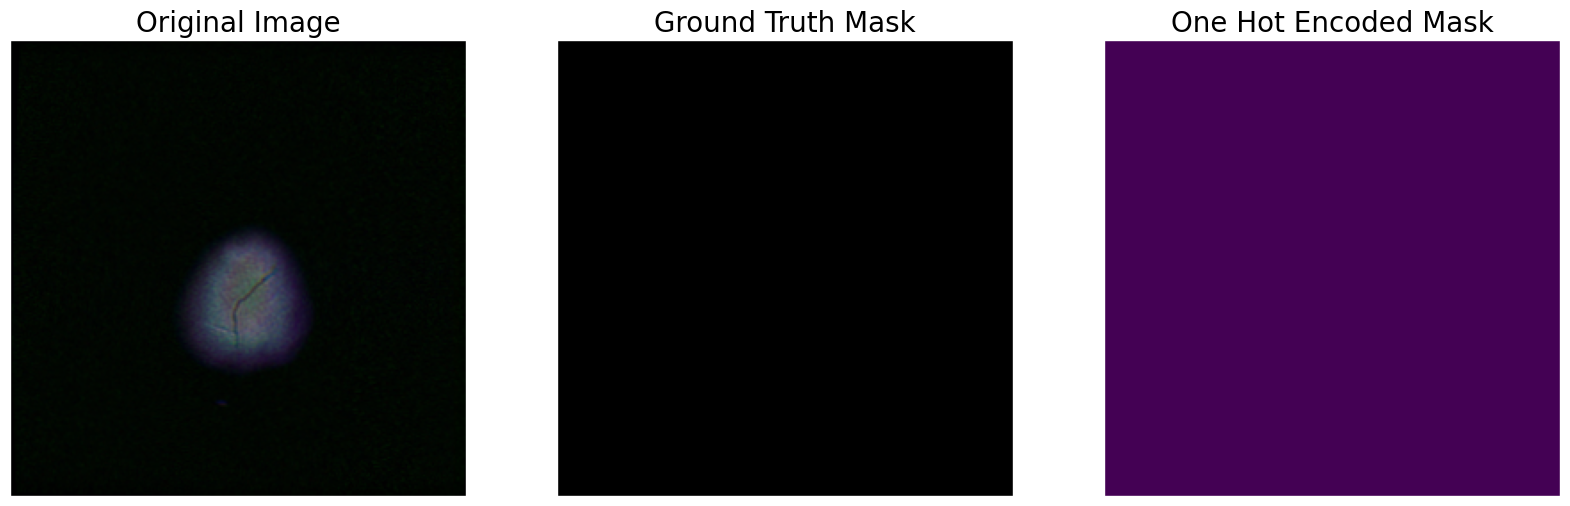

In [ ]:
# Define the RGB values for the classes in the segmentation task
# two classes are defined: one for the background ([0, 0, 0] - black)
#and one for the segmentation target ([255, 255, 255] - white)
select_class_rgb_values = [[0, 0, 0], [255, 255, 255]]
dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

plot_imgs(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

##Augmentations

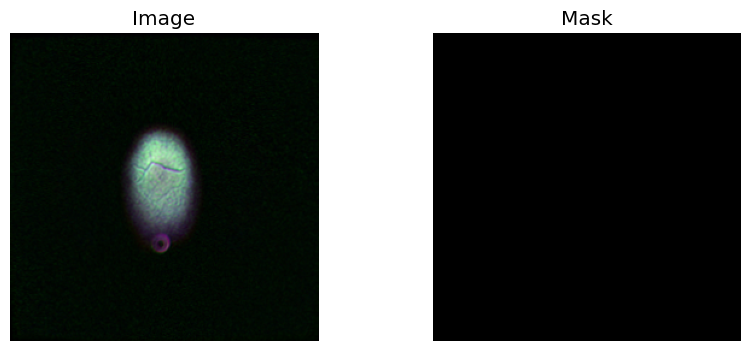

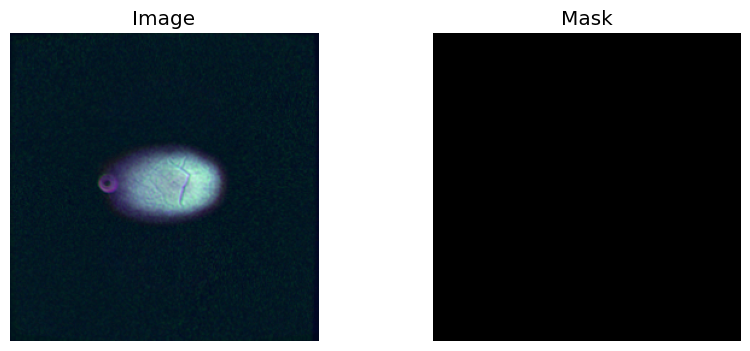

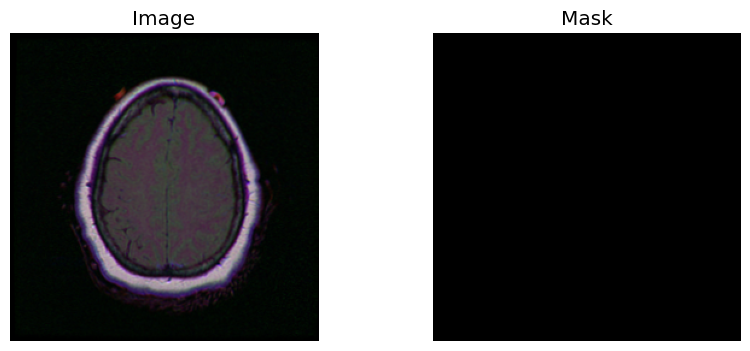

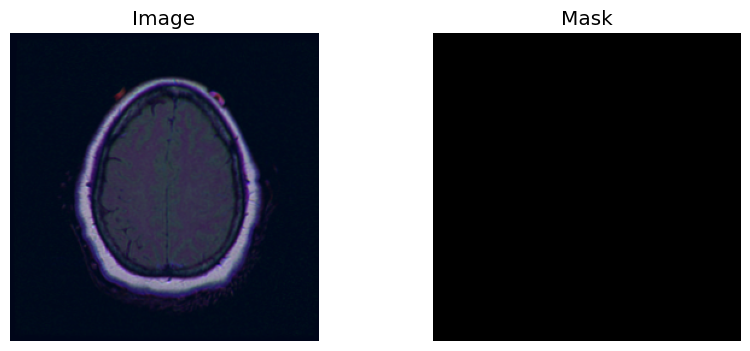

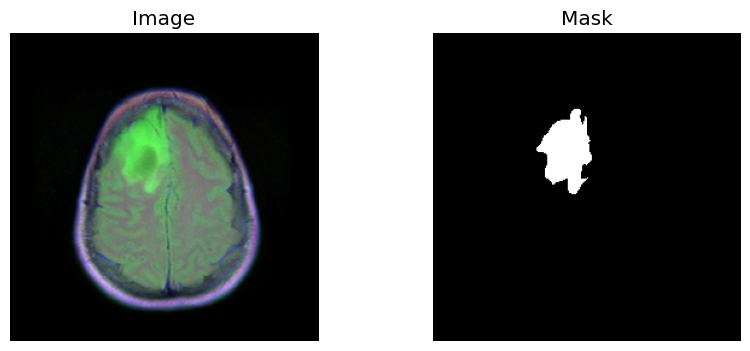

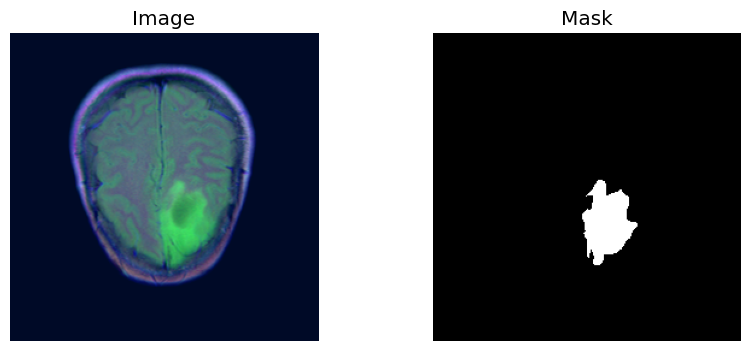

In [ ]:
import albumentations as A

def training_augmentation():
    train_transform = [
        A.RandomCrop(height=256, width=256, always_apply=True), # Crops a random part of the input image to the specified height and width
        A.HorizontalFlip(p=0.8), # Flips the input image horizontally (left to right) with a probability of 0.8.
        A.VerticalFlip(p=0.8), # Flips the input image vertically (top to bottom) with a probability of 0.8.
        A.RandomRotate90(p=0.8), # Rotates the input image by 90 degrees either clockwise or counterclockwise with a probability of 0.8
        # A.OneOf([
        #     A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        #     A.GridDistortion(p=0.5),
        #     A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)
        # ], p=0.7),
        A.CLAHE(p=0.5), # Enhances the contrast of the image by applying adaptive histogram equalization, which is particularly useful for improving the visibility of features in medical images
        A.RandomBrightnessContrast(p=0.5), # Randomly changes the brightness and contrast of the image with a probability of 0.5.
        A.RandomGamma(p=0.5), # Adjusts the gamma of the image, which can alter the luminance of the image, making it either darker or lighter
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Scales the pixel values of the image to have a certain mean and standard deviation
    ]
    return A.Compose(train_transform) #applies sequentially to the input images and masks



select_class_rgb_values = [[0, 0, 0], [255, 255, 255]]
dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values)

def draw_imgs(image, mask):
    plt.figure(figsize=(10, 4))
    # rescale the image to the range [0, 1] for floats
    display_image = np.copy(image)
    if image.max() > 1 or image.min() < 0:
        display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min())
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(display_image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Mask')

    display_mask = np.copy(mask)
    if display_mask.ndim == 3 and display_mask.shape[2] == 1:
        display_mask = display_mask.squeeze(axis=2)  # remove the channel dimension if it's 1
    elif display_mask.ndim == 3 and display_mask.shape[2] == 2:
        display_mask = display_mask[..., 1]  # select one channel if mask has an unexpected shape
    plt.imshow(display_mask, cmap='gray')
    plt.axis('off')
    plt.show()

#visualize 3 random samples with their original and augmented versions
for i in range(3):
    # get a random sample
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    augmentation = training_augmentation()
    augmented = augmentation(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    #original and augmented images and masks
    draw_imgs(image, mask)
    draw_imgs(augmented_image, augmented_mask)

In [ ]:
import albumentations as A

def validation_augmentations():
    return A.Compose([
        #Ensures that the image has a minimum height and width of 256 pixels.
        #If the image is smaller than these dimensions, padding is added to reach the required size.
        #border_mode=0 specifies that the padding should be filled with a constant value of 0 (black).
        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True),
    ])
    return A.Compose([padding_transform])

def convert_to_tensor(x, **kwargs):
    if x.ndim == 2:
        x = x[:, :, None]
    return x.transpose(2, 0, 1).astype('float32')

def apply_preprocessing(preprocessing_function=None):
    transformations = []
    if preprocessing_function:
        transformations.append(A.Lambda(image=preprocessing_function))
    transformations.append(A.Lambda(image=convert_to_tensor, mask=convert_to_tensor))
    return A.Compose(transformations)

## Models

## DEEPLABV3+

In [ ]:
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch import utils

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

# Define auxiliary parameters for the model
aux_params = dict(
    pooling='avg',  # Type of pooling layer
    dropout=0.3,  # Dropout rate
    activation=ACTIVATION,  # Activation function
    classes=1,  # Number of output classes
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 274MB/s] 


In [ ]:
# Get the preprocessing function specific to the chosen encoder
preprocessing_function =  smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# dataset initialization with one_hot_encode=False
train_dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    augmentation=training_augmentation(), preprocessing=apply_preprocessing(preprocessing_function))
valid_dataset = LGGDataset(df_val, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    augmentation=validation_augmentations(), preprocessing=apply_preprocessing(preprocessing_function))
test_dataset = LGGDataset(df_test, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    preprocessing=apply_preprocessing(preprocessing_function))  # No augmentation for test dataset
# Initialize DataLoaders for training, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=3)

In [ ]:
from segmentation_models_pytorch import utils
import torch
from tqdm.auto import tqdm

def train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss_fn, metrics, device, epochs):
    best_iou_score = 0.0
    train_losses = []
    valid_losses = []
    iou_scores = []
    f_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, targets in train_iterator:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # If the model returns a tuple (as in some smp models), use the first element as the output
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_iterator.set_postfix(loss=loss.item())# Update the progress bar with the current loss

        model.eval()
        valid_loss = 0.0
        iou_scores_epoch = []
        f_scores_epoch = []

        iou_metric = smp.utils.metrics.IoU(threshold=0.55)

        valid_iterator = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]", leave=False)
        with torch.no_grad():
            for images, targets in valid_iterator:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                # If the model returns a tuple (as in some smp models), use the first element as the output
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = loss_fn(outputs, targets)
                valid_loss += loss.item()

                # Compute IoU score for each batch
                iou_score_batch = iou_metric(outputs, targets).item()
                iou_scores_epoch.append(iou_score_batch)

                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.55).float()

                # tp = (outputs * targets).sum().item()
                # fp = ((outputs == 1) & (targets == 0)).sum().item()
                # fn = ((outputs == 0) & (targets == 1)).sum().item()
                # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                # recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                # f1_score_batch = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                # f_scores_epoch.append(f1_score_batch)

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        avg_iou_score = sum(iou_scores_epoch) / len(iou_scores_epoch)
        #avg_f1_score = sum(f_scores_epoch) / len(f_scores_epoch)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        iou_scores.append(avg_iou_score)
        #f_scores.append(avg_f1_score)

        tqdm.write(f'\nEpoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, IoU: {avg_iou_score:.4f}')

        if avg_iou_score > best_iou_score:
            best_iou_score = avg_iou_score
            model_save_path = f'/content/{model_name}_best.pth'
            torch.save(model.state_dict(), model_save_path)
            tqdm.write(f'Model saved to {model_save_path} with IoU: {best_iou_score:.4f}')

    # Plotting the training and validation losses, IoU, and F-scores
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, iou_scores, label='IoU Score')
    #plt.plot(epochs_range, f_scores, label='F1 Score')
    plt.legend(loc='upper left')
    plt.title('IoU')
    plt.show()

    return best_iou_score


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define a custom loss class that combines Dice loss and BCE loss
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.utils.losses.DiceLoss() # Initialize Dice loss
        self.bce_loss = nn.BCEWithLogitsLoss()  # Initialize BCE loss with logits
        self.__name__ = 'combined_loss'

    def forward(self, inputs, targets):
        if isinstance(inputs, tuple):
            inputs_main = inputs[0]
        else:
            inputs_main = inputs

        dice = self.dice_loss(torch.sigmoid(inputs_main), targets)  #sigmoid for DiceLoss
        bce = self.bce_loss(inputs_main, targets)  # BCEWithLogitsLoss applies sigmoid internally
        return dice + bce

Training and validating model: DeepLabV3+


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.6686, Valid Loss: 1.6698, IoU: 0.8081
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8081


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6662, Valid Loss: 1.6687, IoU: 0.8206
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8206


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6650, Valid Loss: 1.6677, IoU: 0.8414
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8414


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6643, Valid Loss: 1.6670, IoU: 0.8548
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8548


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6639, Valid Loss: 1.6666, IoU: 0.8660
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8660


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6635, Valid Loss: 1.6669, IoU: 0.8562


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6634, Valid Loss: 1.6662, IoU: 0.8741
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8741


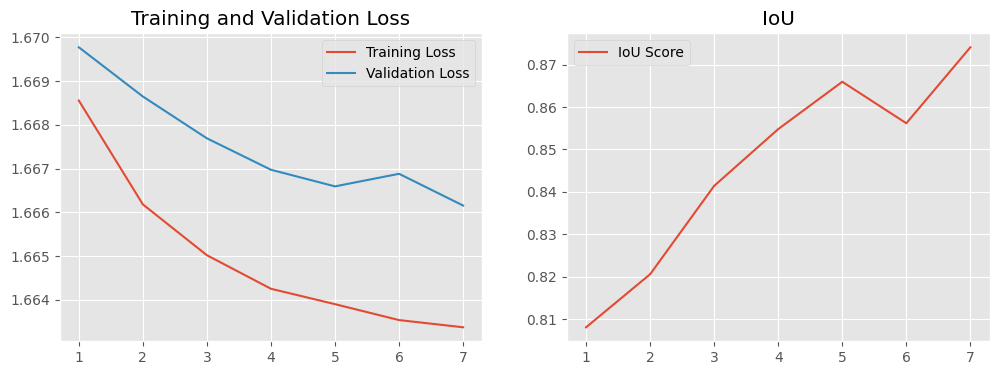

The best model is DeepLabV3+ with an IoU score of 0.874088361063931


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import gc

model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.55)]

torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

best_model_name = max(model_scores, key=model_scores.get)
print(f"The best model is {best_model_name} with an IoU score of {model_scores[best_model_name]}")

In [ ]:
models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: DeepLabV3+
iou_score: 0.8739


In [ ]:
model = smp.DeepLabV3Plus(**common_params)
model_path = '/content/DeepLabV3+_best.pth'
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE)

## Draw predictions

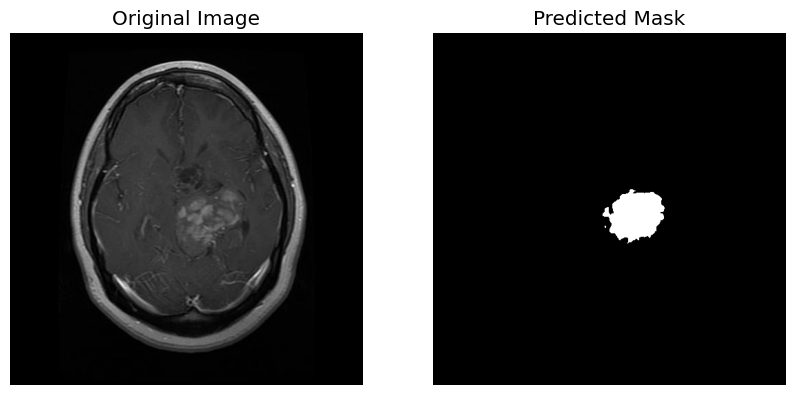

In [ ]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=MEAN, std=STD)
])


img_path = "/content/glioma_tumor.jpg"
img = Image.open(img_path).convert('RGB')
input_image = transform(img)
input_image = input_image.unsqueeze(0).to(DEVICE)  # Add batch dimension and send to device

model.eval()
with torch.no_grad():
    output = model(input_image)
    if isinstance(output, tuple):
        output = output[0]
    prediction = torch.sigmoid(output)
    predicted_mask = (prediction > 0.55).float()


plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 2, 2)
predicted_mask_np = predicted_mask.cpu().squeeze().numpy()
plt.imshow(predicted_mask_np, cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

[[0.5005417  0.5004587  0.50038844 ... 0.50050575 0.50056475 0.50063056]
 [0.50039417 0.50032586 0.5002693  ... 0.50034386 0.50039554 0.5004549 ]
 [0.50028676 0.50023144 0.50018674 ... 0.50023377 0.500277   0.5003282 ]
 ...
 [0.5005994  0.50047004 0.5003686  ... 0.5003242  0.50040114 0.5004964 ]
 [0.5008303  0.50062823 0.5004753  ... 0.50036025 0.5004278  0.5005079 ]
 [0.5011498  0.50083953 0.5006128  ... 0.5004004  0.5004561  0.5005196 ]]


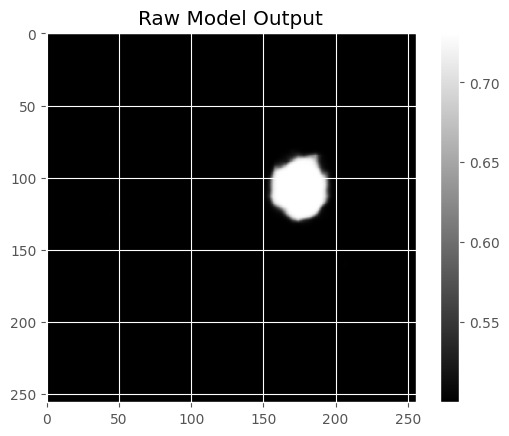

In [ ]:
input_image, _ = test_dataset[5]
input_image = torch.from_numpy(input_image) if isinstance(input_image, np.ndarray) else input_image
input_image = input_image.unsqueeze(0).to(DEVICE)
model.eval()
with torch.no_grad():
    input_image = torch.from_numpy(input_image) if isinstance(input_image, np.ndarray) else input_image
    output = model(input_image)
    if isinstance(output, tuple):
        output = output[0]
    output = torch.sigmoid(output)
    output = output.cpu().squeeze().numpy()
    print(output)

plt.imshow(output, cmap='gray')
plt.title('Raw Model Output')
plt.colorbar()
plt.show()

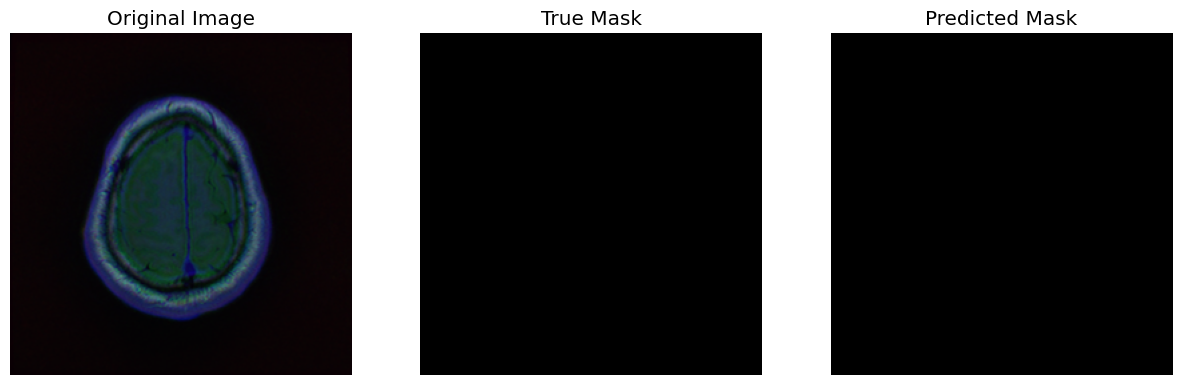

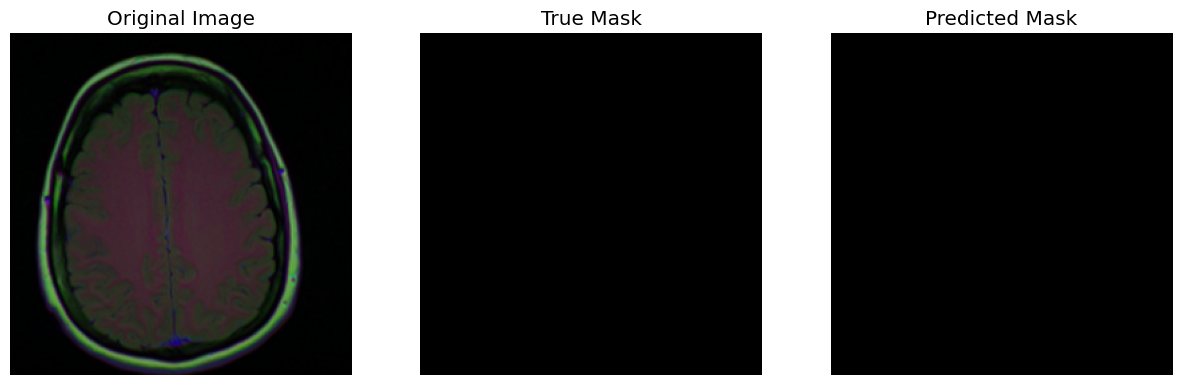

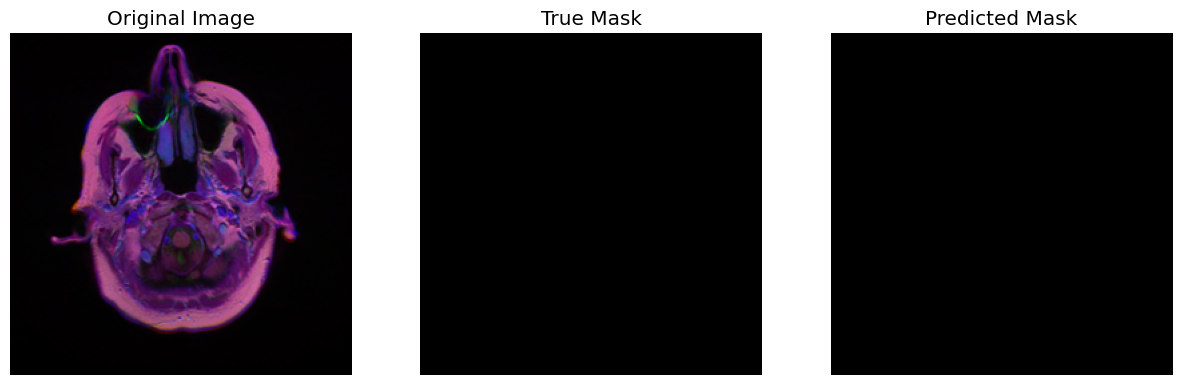

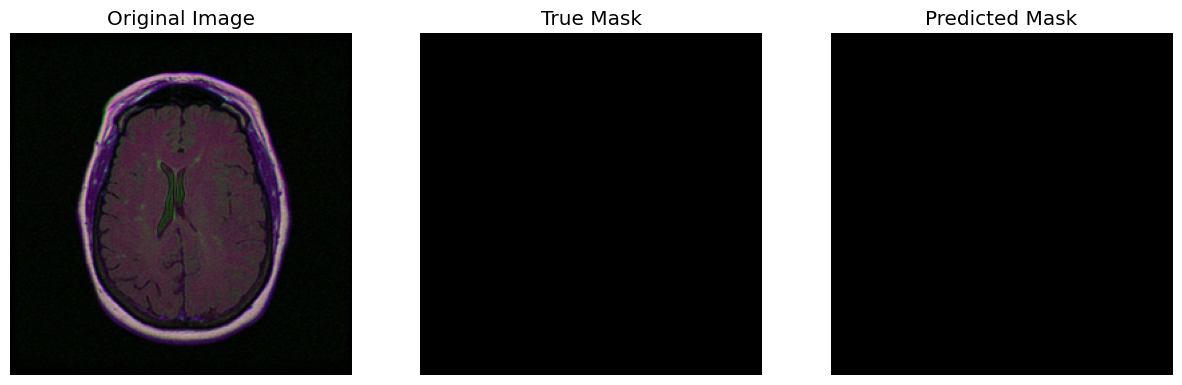

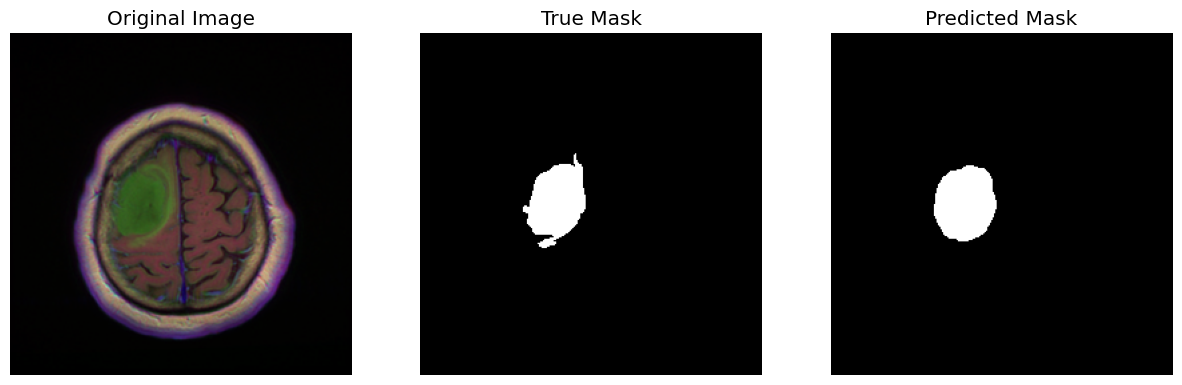

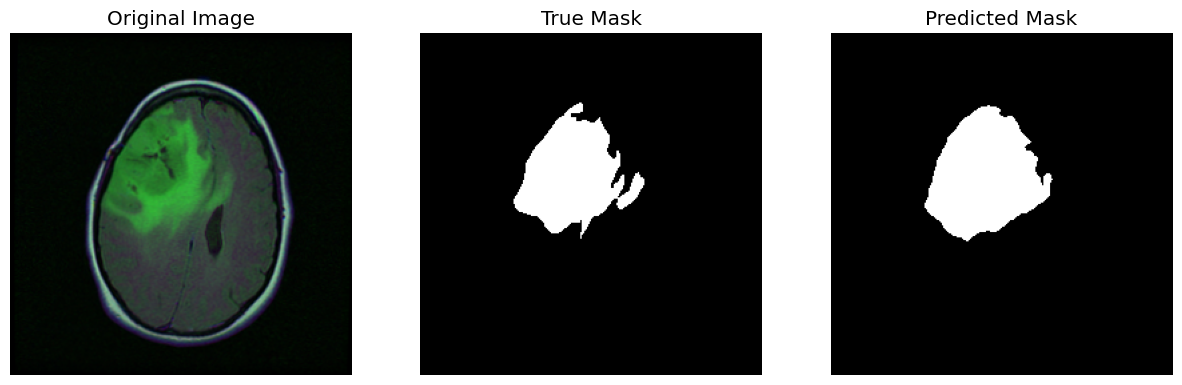

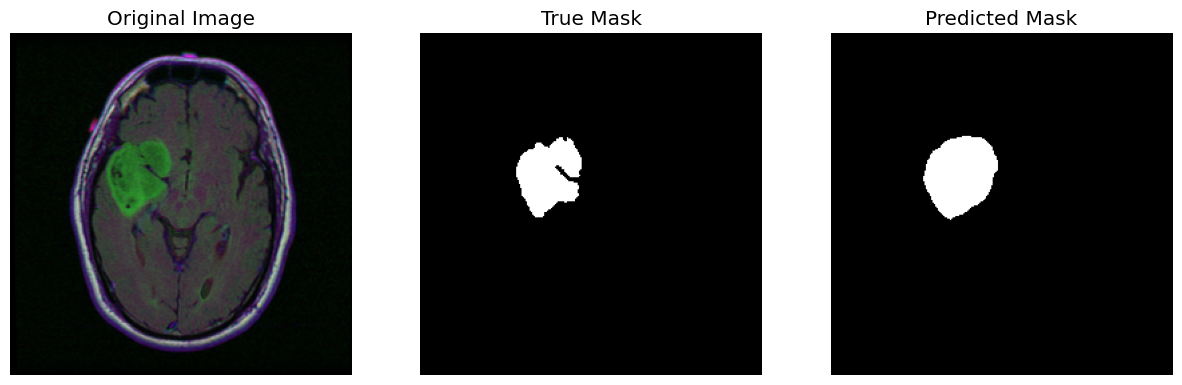

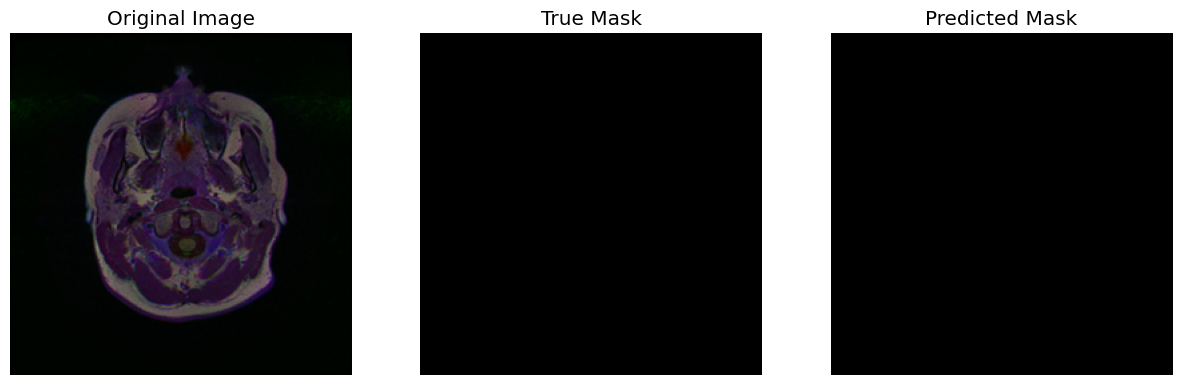

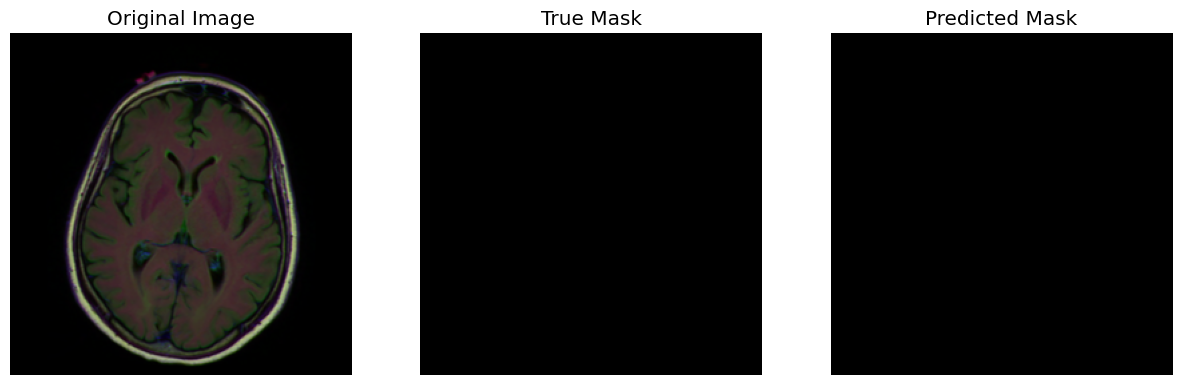

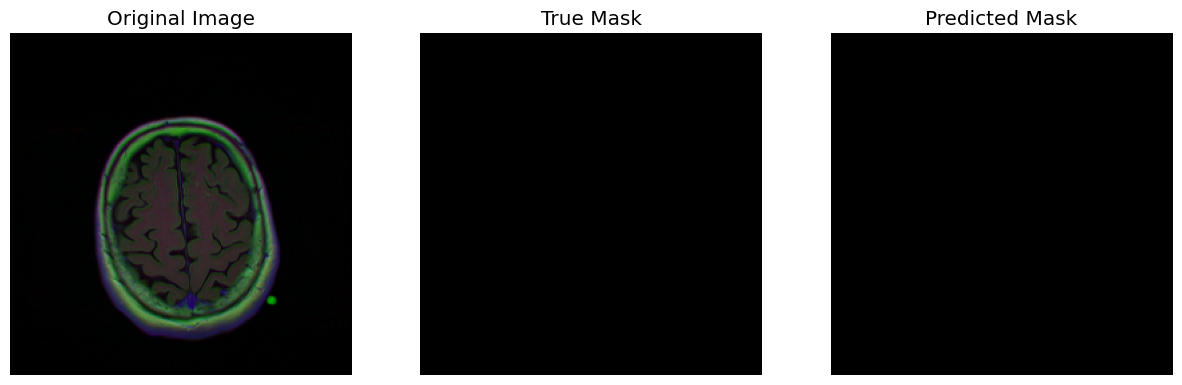

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import random

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(image):
    # Ensure image is in the shape (channels, height, width)
    if image.ndim == 3 and image.shape[-1] == 3:
        image = image.transpose(2, 0, 1)
    # Reverse the normalization process
    image = (image * STD[:, None, None]) + MEAN[:, None, None]
    # Ensure image is in the shape (height, width, channels) for visualization
    if image.ndim == 3:
        image = image.transpose(1, 2, 0)
    # Clip values to ensure they are between 0 and 1, as imshow expects
    image = np.clip(image, 0, 1)
    return image

def visualize_random_predictions(model, dataset, device, num_images=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
            mask = torch.from_numpy(mask) if isinstance(mask, np.ndarray) else mask
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            outputs = model(image)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predictions = torch.sigmoid(outputs)
            predicted_masks = (predictions > 0.55).float()

            plt.figure(figsize=(15, 5))

            # Original Image (denormalized)
            image_np = image[0].cpu().numpy()
            image_denorm = denormalize(image_np)
            plt.subplot(1, 3, 1)
            plt.imshow(image_denorm)
            plt.title('Original Image')
            plt.axis('off')

            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].cpu().squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[0].cpu().squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

visualize_random_predictions(model, test_dataset, device, num_images=10)

## UNET++

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: Unet++


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.8502, Valid Loss: 1.7714, IoU: 0.0908
Model saved to /content/Unet++_best.pth with IoU: 0.0908


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.7388, Valid Loss: 1.7194, IoU: 0.7734
Model saved to /content/Unet++_best.pth with IoU: 0.7734


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.7058, Valid Loss: 1.6999, IoU: 0.8297
Model saved to /content/Unet++_best.pth with IoU: 0.8297


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6907, Valid Loss: 1.6886, IoU: 0.8418
Model saved to /content/Unet++_best.pth with IoU: 0.8418


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6821, Valid Loss: 1.6815, IoU: 0.8575
Model saved to /content/Unet++_best.pth with IoU: 0.8575


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6765, Valid Loss: 1.6776, IoU: 0.8423


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6730, Valid Loss: 1.6750, IoU: 0.8544


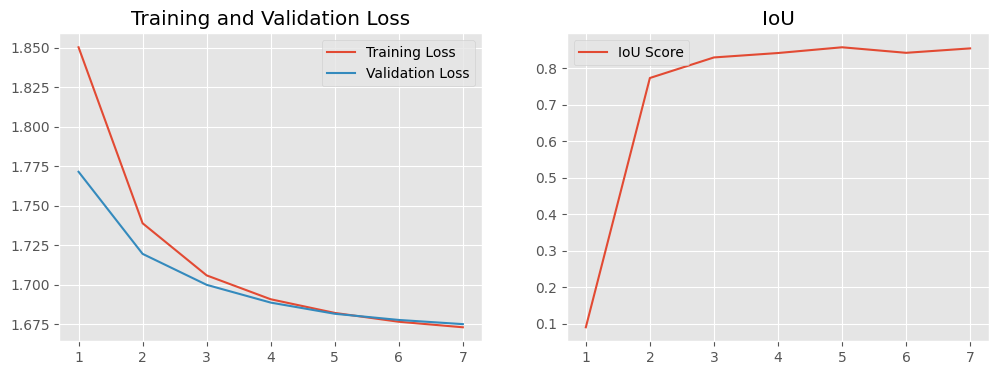

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: Unet++
iou_score: 0.8268


In [ ]:
model = smp.UnetPlusPlus(**common_params)
model_path = '/content/Unet++_best.pth'
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE)

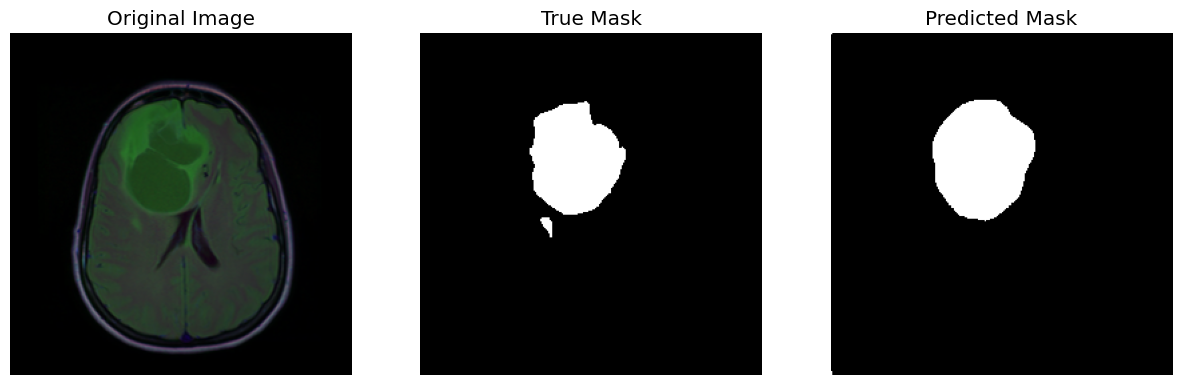

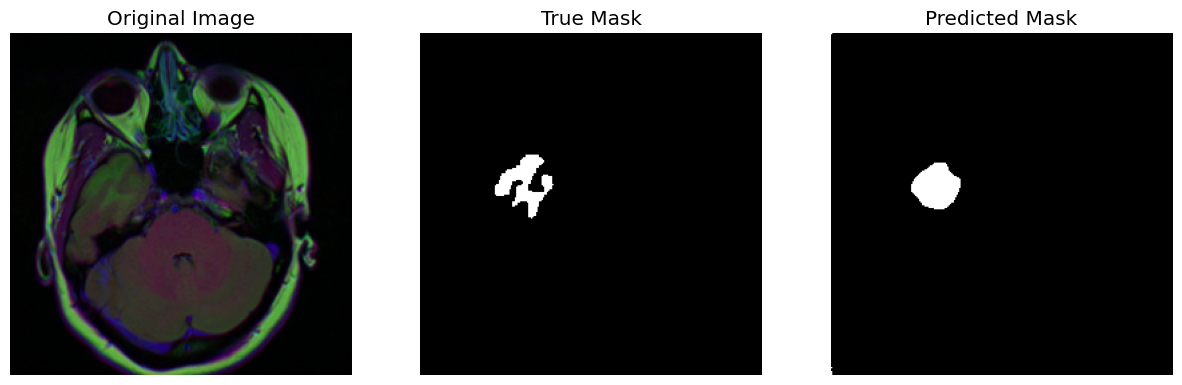

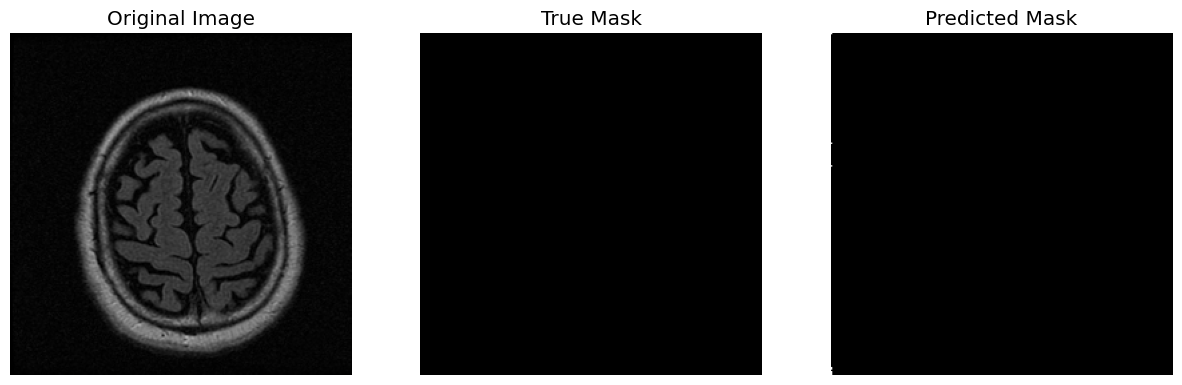

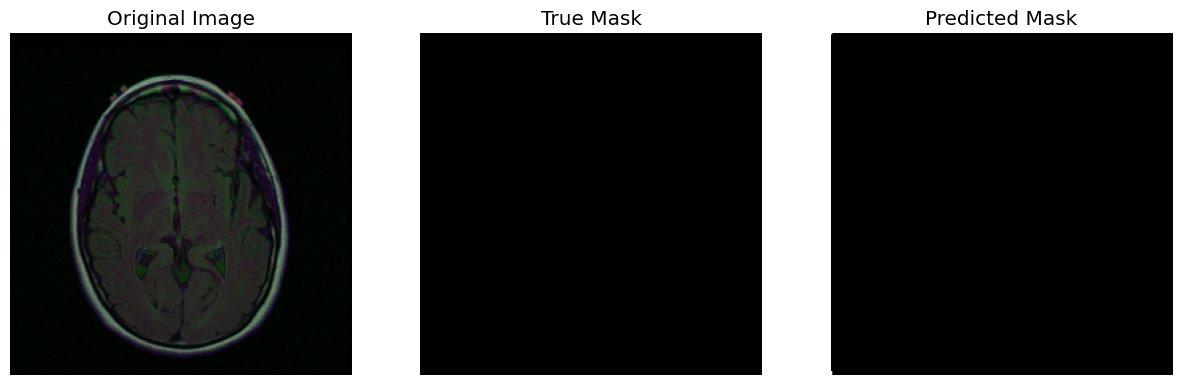

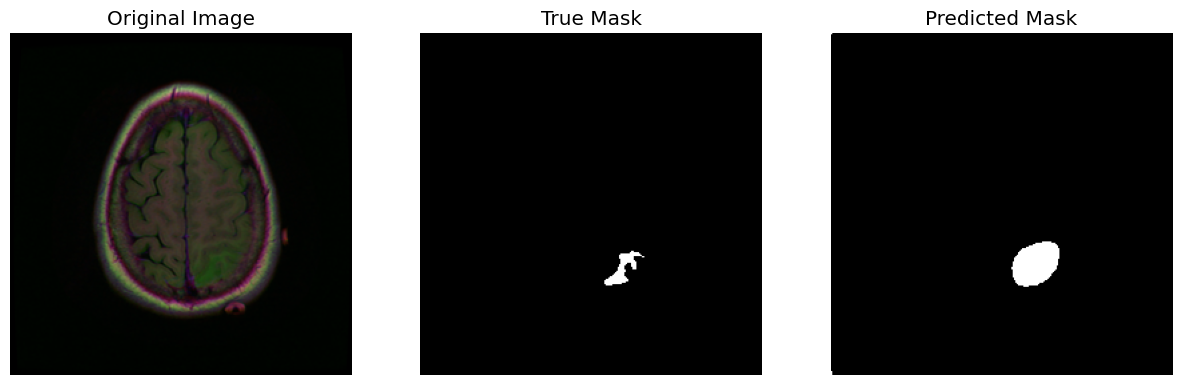

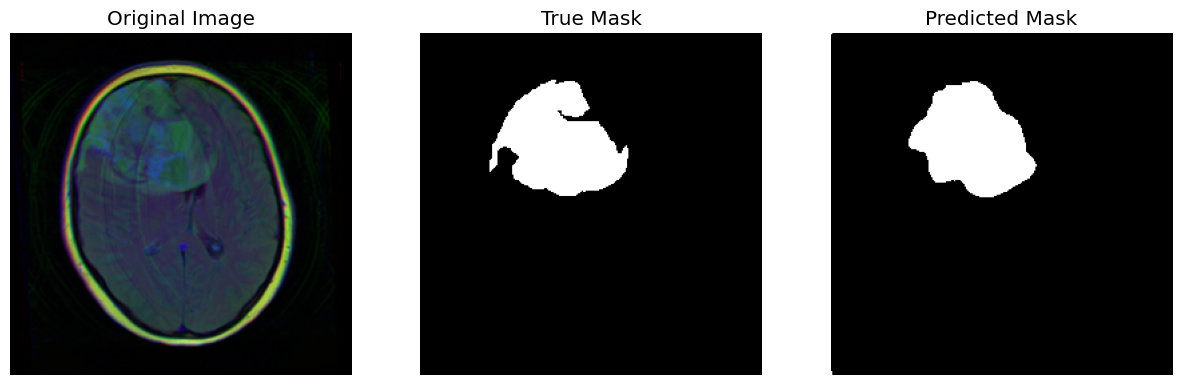

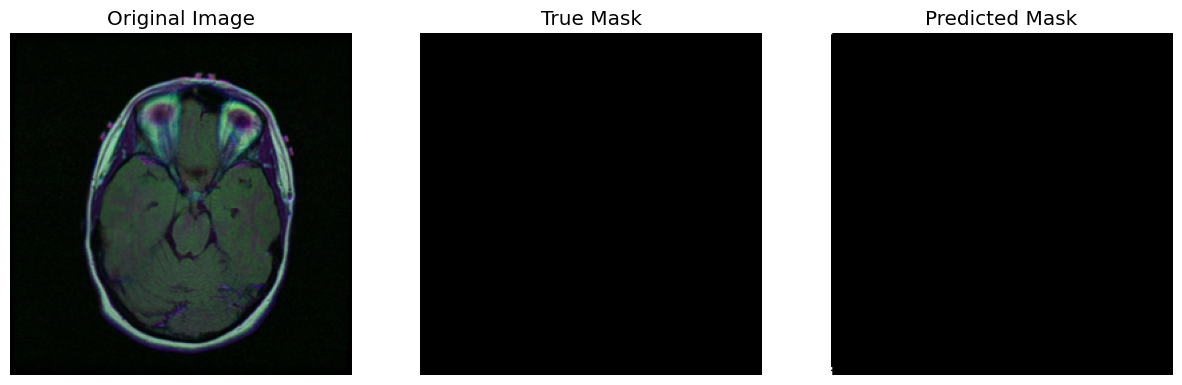

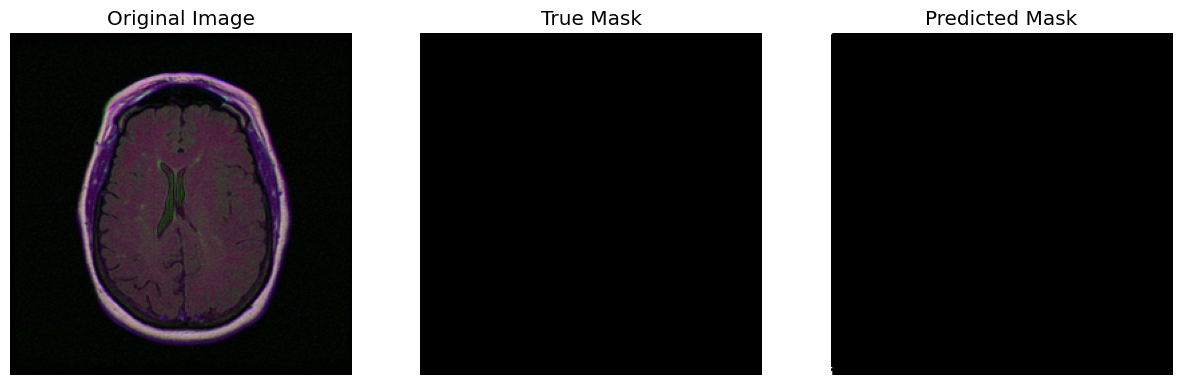

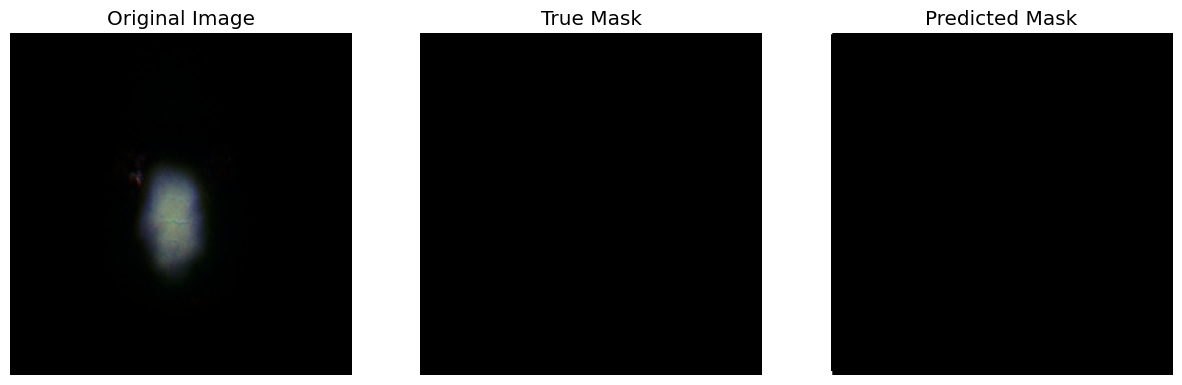

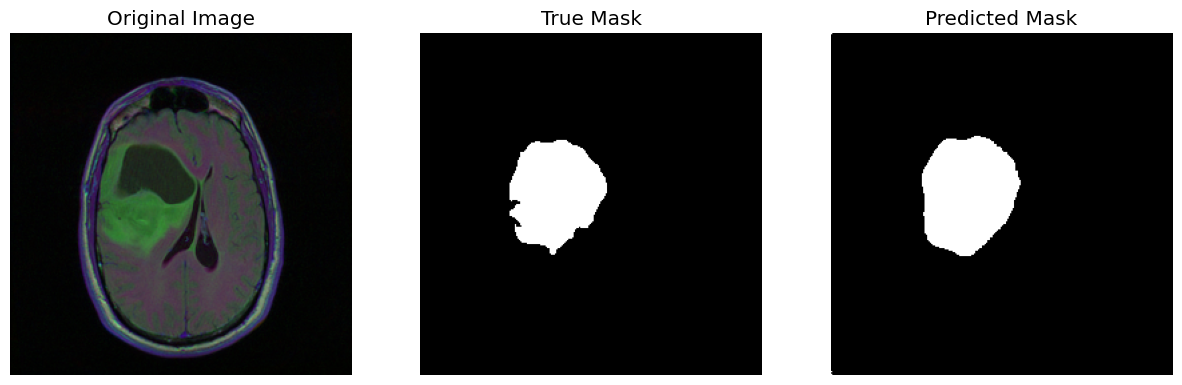

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import random

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(image):
    if image.ndim == 3 and image.shape[-1] == 3:
        image = image.transpose(2, 0, 1)
    image = (image * STD[:, None, None]) + MEAN[:, None, None]
    if image.ndim == 3:
        image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    return image

def visualize_random_predictions(model, dataset, device, num_images=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
            mask = torch.from_numpy(mask) if isinstance(mask, np.ndarray) else mask
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            outputs = model(image)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predictions = torch.sigmoid(outputs)
            predicted_masks = (predictions > 0.55).float()

            plt.figure(figsize=(15, 5))

            # Original Image (denormalized)
            image_np = image[0].cpu().numpy()
            image_denorm = denormalize(image_np)
            plt.subplot(1, 3, 1)
            plt.imshow(image_denorm)
            plt.title('Original Image')
            plt.axis('off')

            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].cpu().squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[0].cpu().squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

visualize_random_predictions(model, test_dataset, device, num_images=10)

##PAN

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: PAN


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.7803, Valid Loss: 1.6906, IoU: 0.1836
Model saved to /content/PAN_best.pth with IoU: 0.1836


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6768, Valid Loss: 1.6785, IoU: 0.6770
Model saved to /content/PAN_best.pth with IoU: 0.6770


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6734, Valid Loss: 1.6725, IoU: 0.7572
Model saved to /content/PAN_best.pth with IoU: 0.7572


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6691, Valid Loss: 1.6708, IoU: 0.7814
Model saved to /content/PAN_best.pth with IoU: 0.7814


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6673, Valid Loss: 1.6696, IoU: 0.7885
Model saved to /content/PAN_best.pth with IoU: 0.7885


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6666, Valid Loss: 1.6691, IoU: 0.8003
Model saved to /content/PAN_best.pth with IoU: 0.8003


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6656, Valid Loss: 1.6683, IoU: 0.8058
Model saved to /content/PAN_best.pth with IoU: 0.8058


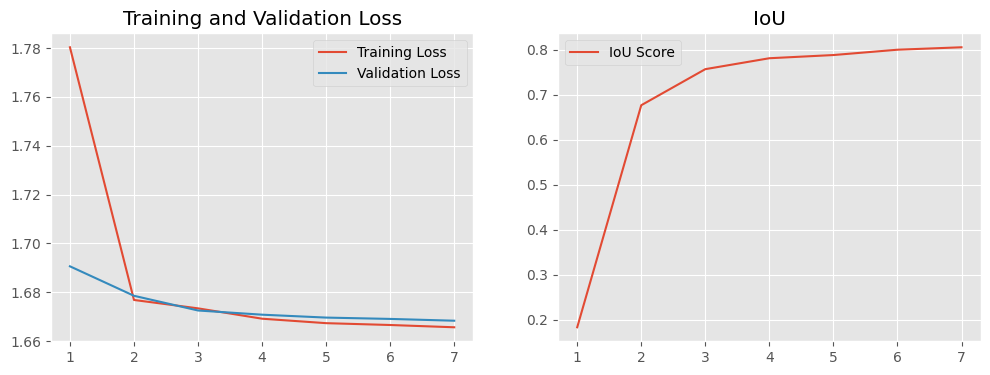

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: PAN
iou_score: 0.7970


## UNET

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: Unet


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.8029, Valid Loss: 1.7525, IoU: 0.5425
Model saved to /content/Unet_best.pth with IoU: 0.5425


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.7204, Valid Loss: 1.7108, IoU: 0.7684
Model saved to /content/Unet_best.pth with IoU: 0.7684


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6947, Valid Loss: 1.6905, IoU: 0.8385
Model saved to /content/Unet_best.pth with IoU: 0.8385


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6822, Valid Loss: 1.6816, IoU: 0.8385
Model saved to /content/Unet_best.pth with IoU: 0.8385


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6755, Valid Loss: 1.6764, IoU: 0.8483
Model saved to /content/Unet_best.pth with IoU: 0.8483


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6715, Valid Loss: 1.6727, IoU: 0.8717
Model saved to /content/Unet_best.pth with IoU: 0.8717


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6691, Valid Loss: 1.6712, IoU: 0.8482


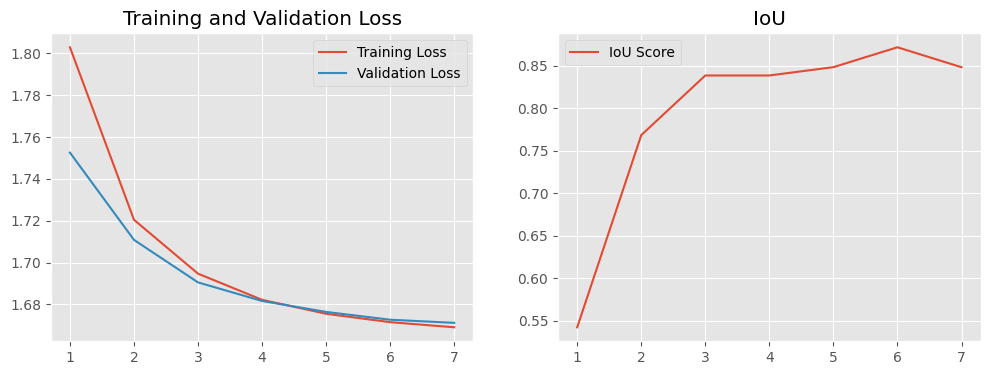

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: Unet
iou_score: 0.8517


## DEEPLABV3

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    'Unet': smp.Unet(**common_params),
    'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    'PAN': smp.PAN(**common_params),
    'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: DeepLabV3


Epoch 1/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.7308, Valid Loss: 1.6883, IoU: 0.3906
Model saved to /content/DeepLabV3_best.pth with IoU: 0.3906


Epoch 2/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6769, Valid Loss: 1.6779, IoU: 0.3717


Epoch 3/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6697, Valid Loss: 1.6729, IoU: 0.5210
Model saved to /content/DeepLabV3_best.pth with IoU: 0.5210


Epoch 4/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6670, Valid Loss: 1.6718, IoU: 0.6123
Model saved to /content/DeepLabV3_best.pth with IoU: 0.6123


Epoch 5/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6656, Valid Loss: 1.6707, IoU: 0.5071


Epoch 6/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6646, Valid Loss: 1.6700, IoU: 0.7845
Model saved to /content/DeepLabV3_best.pth with IoU: 0.7845


Epoch 7/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6640, Valid Loss: 1.6696, IoU: 0.7309


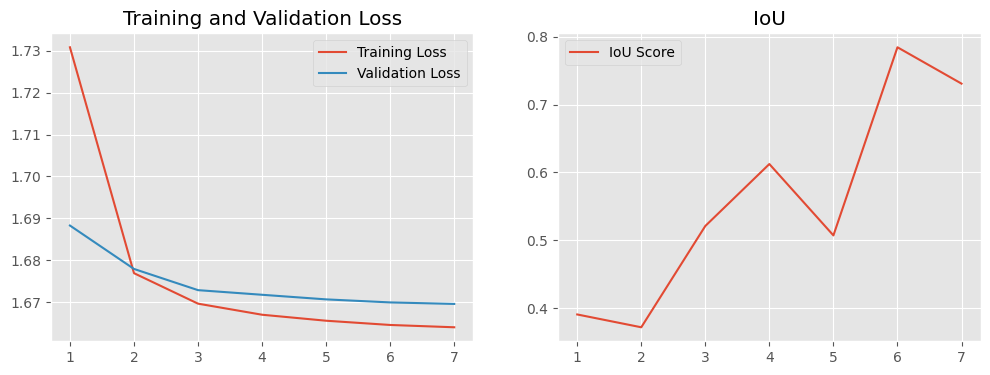

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: DeepLabV3
iou_score: 0.7986
